### Análisis Geomecánico de Información de Registros Geofísicos de Pozo
#### Versión 01 - Octubre de 2019

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from IPython.display import Image

%matplotlib inline
plt.style.use('seaborn-white')

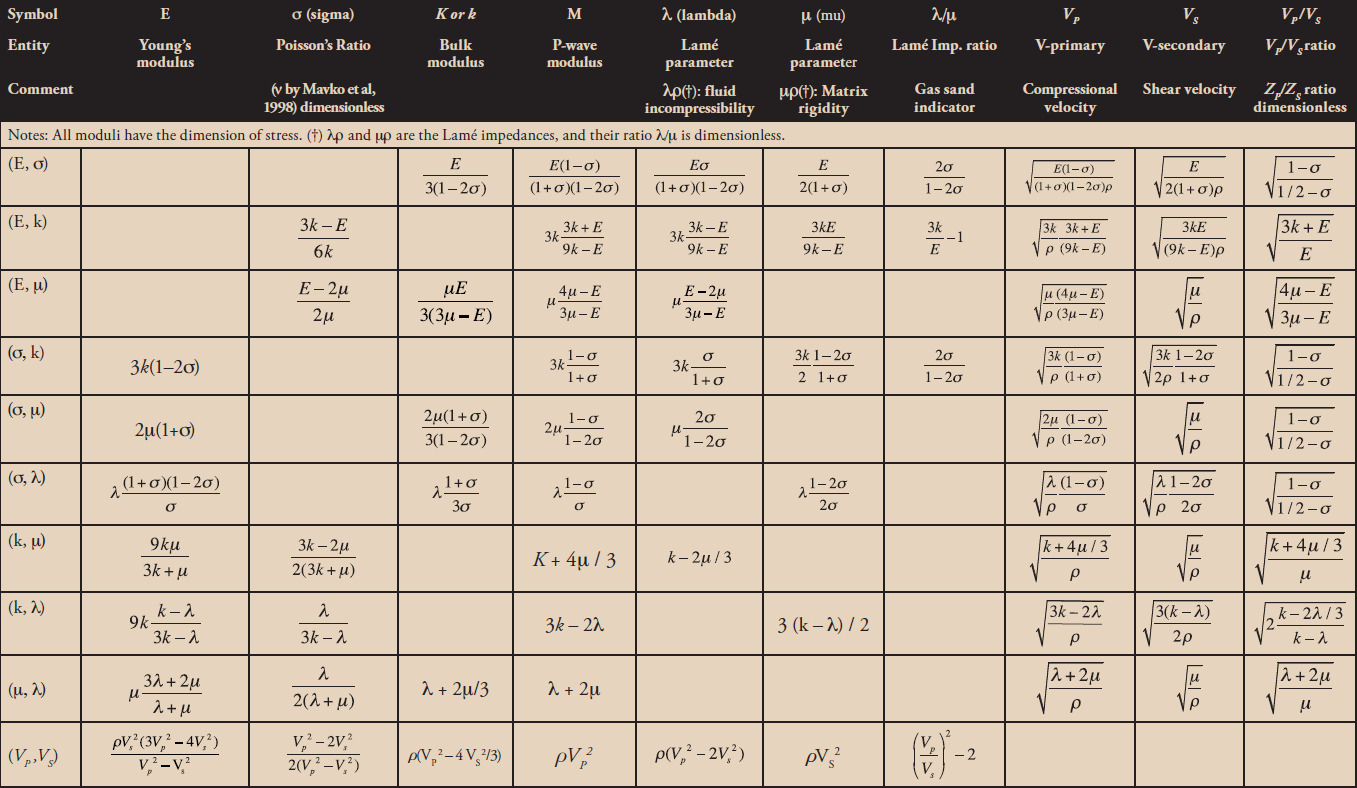

In [2]:
Image(filename="elastic_constants.png", width=1000,height=500)

Tabla de constantes elásticas para medios isótropos ([Smidt, 2009](https://library.seg.org/doi/10.1190/1.3064156))

Importar base de datos

In [3]:
datos = pd.read_csv('datos01_chicon.csv')

Nombre de las columnas

In [4]:
datos.columns

Index(['DEPTH_m', 'DTC_us/ft', 'DTC_us/m', 'Vp_km/s', 'DTSM_us/ft',
       'DTSM_us/m', 'Vs_km/s', 'Vp/Vs', 'GR_gapi', 'RHOZ_g/cc', 'RHOZ_kg/m3',
       'PHI_%', 'ShearModulus_MPa', 'Poisson_Ratio_adim', 'Bulk_Modulus_MPa',
       'Biot_Coeff_adim', 'Young_Modulus_MPa', 'UCS_MPa', 'UCS_MPa.1',
       'Tension_MPa', 'Friccion_Interna_grad', 'Pp_MPa', 'Pov_MPa', 'Sh_MPa',
       'SH_MPa', 'UCS_MPa.2'],
      dtype='object')

In [5]:
datos.describe()

,DEPTH_m,DTC_us/ft,DTC_us/m,Vp_km/s,DTSM_us/ft,DTSM_us/m,Vs_km/s,Vp/Vs,GR_gapi,RHOZ_g/cc,...,Young_Modulus_MPa,UCS_MPa,UCS_MPa.1,Tension_MPa,Friccion_Interna_grad,Pp_MPa,Pov_MPa,Sh_MPa,SH_MPa,UCS_MPa.2
count,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,...,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000
mean,1588.693800,93.425373,306.457645,3.293903,201.388482,660.723386,1.547177,2.152331,72.914597,2.528805,...,16.685441,71.976563,104.419812,7.197656,47.226220,15.569199,36.244386,27.027010,31.868778,0.135996
std,106.751658,9.218593,30.239196,0.322440,30.826769,101.137696,0.224247,0.216073,10.772104,0.045775,...,4.507221,18.827398,23.759331,1.882740,2.827196,1.046166,2.435427,2.311285,2.273810,0.024591
min,1403.908800,61.025000,200.176646,2.108765,118.039800,387.269697,0.887207,1.304663,27.967200,2.167910,...,5.683101,25.446876,12.110542,2.544688,24.940000,13.758306,32.028710,12.568675,27.932857,0.006096
25%,1496.301300,87.125425,285.792304,3.036382,179.000475,587.271918,1.370859,2.025118,65.470375,2.507217,...,12.939991,56.365312,89.121696,5.636531,45.890000,14.663753,34.136548,25.583747,29.900818,0.122271
50%,1588.693800,91.609650,300.501638,3.327160,193.283700,634.132894,1.576957,2.128127,73.906100,2.542880,...,17.139538,73.958461,109.923237,7.395846,48.095000,15.569199,36.244386,26.827448,31.868778,0.143049
75%,1681.086300,100.382625,329.279102,3.498405,222.342350,729.469676,1.702789,2.271650,80.322450,2.557357,...,19.794550,85.003946,119.694657,8.500395,48.990000,16.474646,38.352225,28.638856,33.836738,0.151949
max,1773.478800,144.539600,474.124578,4.994674,343.550000,1127.132582,2.582180,3.848481,135.049300,2.704580,...,33.731067,142.288175,284.564142,14.228818,58.080000,17.380092,40.460063,35.071434,35.804698,0.257709


In [6]:
prof = datos['DEPTH_m']
vp = datos['Vp_km/s']
vpvs = datos['Vp/Vs']
dtco = datos['DTC_us/m'] # Error de conversión en la tabla original
dtsm = datos['DTSM_us/m']
den =  datos['RHOZ_kg/m3']
gr = datos['GR_gapi']
phi = datos['PHI_%']

In [7]:
vp = vp * 1000
vs = 1000000/dtsm

Filtro de valores impulsivos (spike) a través de valores límites para los valores de velocidad de onda P y S y densidad volumétrica

In [8]:
vp_cutoff = np.where(vp < 4200, vp, 4200)
vp_cutoff = np.where(vp_cutoff > 2600, vp_cutoff, 2600)

In [9]:
vs_cutoff = np.where(vs < 2050, vs, 2050)
vs_cutoff = np.where(vs_cutoff > 1000, vs_cutoff, 1000)

In [10]:
den_cutoff = np.where(den < 2650, den, 2650)
den_cutoff = np.where(den_cutoff > 2350, den_cutoff, 2350)

Cálculo de propiedades mecánicas

In [11]:
def corte(den,vs):
    '''Módulo de corte [Pa]'''
    corte = den * vs**2
    return corte

In [12]:
def poisson(vp,vs):
    '''Relación de Poisson [1]'''
    poisson =0.5 * (vp**2 - 2*vs**2)/(vp**2 - vs**2)
    return poisson

In [13]:
def bulk(E,nu):
    '''Módulo volumétrico [Pa]'''
    bulk = E/(3*(1-2*nu)) 
    return bulk

In [14]:
def biot(Kb,Km):
    '''Constante de Biot [1]'''
    biot = 1-(Kb/Km)  
    return biot

In [15]:
def young(G,nu):
    '''Módulo de Young [Pa]'''
    young = 2 * G * (1 + nu)  
    return young

In [16]:
nu = poisson(vp,vs)
nus = poisson(vp_cutoff,vs_cutoff)

In [17]:
G =  corte(den,vs)
Gs =  corte(den_cutoff,vs_cutoff)

In [18]:
E = young(G,nu)
Es = young(Gs,nus)

In [19]:
Kb = bulk(E,nu)
Kbs = bulk(Es,nus)

In [20]:
Km = 38.33 * 1e9
alpha = biot(Kb,Km)
alphas = biot(Kbs,Km)

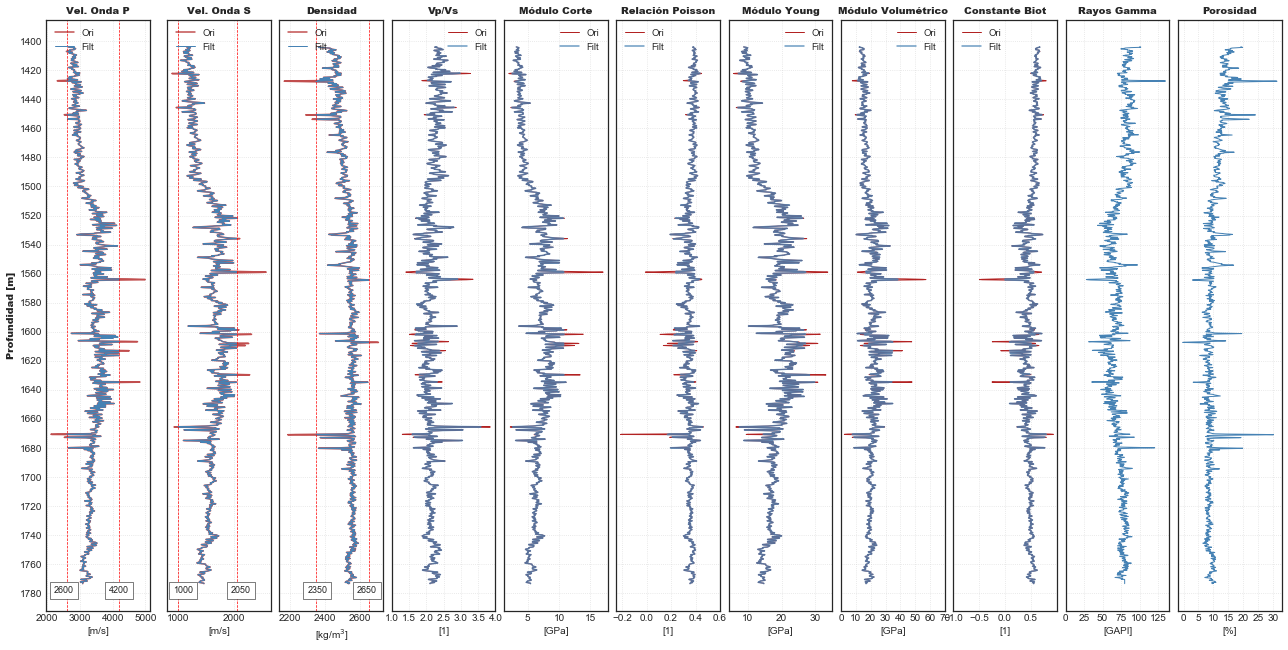

In [21]:
f1 = plt.figure(figsize=[12,10])

ax1 = f1.add_axes([0.0, 0.1, 0.12, 0.82])
ax1.plot(vp,prof,'firebrick', alpha=0.8, lw=1.5, label = 'Ori')
ax1.plot(vp_cutoff,prof,'steelblue', alpha=1, lw=1, label = 'Filt')
ax1.set_title('Vel. Onda P', style = 'normal', fontsize = 10, weight = 'black')
ax1.set_ylabel('Profundidad [m]', fontsize = 10, weight='black')
ax1.set_xlabel('[m/s]', fontsize = 10)
ax1.set_yticks(np.arange(1400,1790,20))
ax1.set_xticks(np.arange(2000,6000,1000))
ax1.axvline(x=2600, color = 'red', lw = 0.7, linestyle = '--')
ax1.axvline(x=4200, color = 'red', lw = 0.7, linestyle = '--')
ax1.text(x = 2200, y = 1780, s = '2600', fontsize = 9, bbox=dict(facecolor='white', alpha=1, lw = 0.5))
ax1.text(x = 3900, y = 1780, s = '4200', fontsize = 9, bbox=dict(facecolor='white', alpha=1, lw = 0.5))
ax1.invert_yaxis()
ax1.legend(fontsize = 9.5, fancybox = False, shadow = False, frameon = False, loc = 'upper left')
ax1.grid(True, alpha = 0.6, linestyle=':')

ax2 = f1.add_axes([0.14, 0.1, 0.12, 0.82])
ax2.plot(vs,prof,'firebrick', alpha=0.8, lw=1.5, label = 'Ori')
ax2.plot(vs_cutoff,prof,'steelblue', alpha=1, lw=1, label = 'Filt')
ax2.set_title('Vel. Onda S', style = 'normal', fontsize = 10, weight = 'black')
ax2.set_yticklabels('')
ax2.set_xlabel('[m/s]', fontsize = 10)
ax2.set_yticks(np.arange(1400,1790,20))
#ax2.set_xticks(np.arange(1000,4000,1000))
ax2.axvline(x=1000, color = 'red', lw = 0.7, linestyle = '--')
ax2.axvline(x=2050, color = 'red', lw = 0.7, linestyle = '--')
ax2.text(x = 900, y = 1780, s = '1000', fontsize = 9, bbox=dict(facecolor='white', alpha=1, lw = 0.5))
ax2.text(x = 1950, y = 1780, s = '2050', fontsize = 9, bbox=dict(facecolor='white', alpha=1, lw = 0.5))
ax2.invert_yaxis()
ax2.legend(fontsize = 9.5, fancybox = False, shadow = False, frameon = False, loc = 'upper left')
ax2.grid(True, alpha = 0.6, linestyle=':')

ax3 = f1.add_axes([0.27, 0.1, 0.12, 0.82])
ax3.plot(den,prof,'firebrick', alpha=0.8, lw=1.5, label = 'Ori')
ax3.plot(den_cutoff,prof,'steelblue', alpha=1, lw=1, label = 'Filt')
ax3.set_title('Densidad', style = 'normal', fontsize = 10, weight = 'black')
ax3.set_yticklabels('')
ax3.set_xlabel('[kg/m$^3$]', fontsize = 10)
ax3.set_yticks(np.arange(1400,1790,20))
ax3.axvline(x=2650, color = 'red', lw = 0.7, linestyle = '--')
ax3.axvline(x=2350, color = 'red', lw = 0.7, linestyle = '--')
ax3.text(x = 2300, y = 1780, s = '2350', fontsize = 9, bbox=dict(facecolor='white', alpha=1, lw = 0.5))
ax3.text(x = 2580, y = 1780, s = '2650', fontsize = 9, bbox=dict(facecolor='white', alpha=1, lw = 0.5))
ax3.invert_yaxis()
ax3.legend(fontsize = 9.5, fancybox = False, shadow = False, frameon = False, loc = 'upper left')
ax3.grid(True, alpha = 0.6, linestyle=':')

ax4 = f1.add_axes([0.40, 0.1, 0.12, 0.82])
ax4.plot(vp/vs,prof,'firebrick', alpha=1, lw=1, label = 'Ori')
ax4.plot(vp_cutoff/vs_cutoff,prof,'steelblue', alpha=0.8, lw=1.5, label = 'Filt')
ax4.set_title('Vp/Vs', style = 'normal', fontsize = 10, weight = 'black')
ax4.set_yticklabels('')
ax4.set_xlabel('[1]', fontsize = 10)
ax4.set_yticks(np.arange(1400,1790,20))
ax4.set_xticks(np.arange(1,4.5,0.5))
ax4.invert_yaxis()
ax4.legend(fontsize = 9.5, fancybox = False, shadow = False, frameon = False, loc = 'upper right')
ax4.grid(True, alpha = 0.6, linestyle=':')

ax5 = f1.add_axes([0.53, 0.1, 0.12, 0.82])
ax5.plot(G/1e9,prof,'firebrick', alpha=1, lw=1, label = 'Ori')
ax5.plot(Gs/1e9,prof,'steelblue', alpha=0.8, lw=1.5, label = 'Filt')
ax5.set_title('Módulo Corte', style = 'normal', fontsize = 10, weight = 'black')
ax5.set_yticklabels('')
ax5.set_xlabel('[GPa]', fontsize = 10)
ax5.set_yticks(np.arange(1400,1790,20))
ax5.invert_yaxis()
ax5.legend(fontsize = 9.5, fancybox = False, shadow = False, frameon = False, loc = 'upper right')
ax5.grid(True, alpha = 0.6, linestyle=':')

ax6 = f1.add_axes([0.66, 0.1, 0.12, 0.82])
ax6.plot(nu,prof,'firebrick', alpha=1, lw=1, label = 'Ori')
ax6.plot(nus,prof,'steelblue', alpha=0.8, lw=1.5, label = 'Filt')
ax6.set_title('Relación Poisson', style = 'normal', fontsize = 10, weight = 'black')
ax6.set_yticklabels('')
ax6.set_xlabel('[1]', fontsize = 10)
ax6.set_yticks(np.arange(1400,1790,20))
ax6.set_xticks(np.arange(-0.2,0.8,0.2))
ax6.invert_yaxis()
ax6.legend(fontsize = 9.5, fancybox = False, shadow = False, frameon = False, loc = 'upper left')
ax6.grid(True, alpha = 0.6, linestyle=':')

ax7 = f1.add_axes([0.79, 0.1, 0.12, 0.82])
ax7.plot(E/1e9,prof,'firebrick', alpha=1, lw=1, label = 'Ori')
ax7.plot(Es/1e9,prof,'steelblue', alpha=0.8, lw=1.5, label = 'Filt')
ax7.set_title('Módulo Young', style = 'normal', fontsize = 10, weight = 'black')
ax7.set_yticklabels('')
ax7.set_xlabel('[GPa]', fontsize = 10)
ax7.set_yticks(np.arange(1400,1790,20))
ax7.invert_yaxis()
ax7.legend(fontsize = 9.5, fancybox = False, shadow = False, frameon = False, loc = 'upper right')
ax7.grid(True, alpha = 0.6, linestyle=':')

ax8 = f1.add_axes([0.92, 0.1, 0.12, 0.82])
ax8.plot(Kb/1e9,prof,'firebrick', alpha=1, lw=1, label = 'Ori')
ax8.plot(Kbs/1e9,prof,'steelblue', alpha=0.8, lw=1.5, label = 'Filt')
ax8.set_title('Módulo Volumétrico', style = 'normal', fontsize = 10, weight = 'black')
ax8.set_yticklabels('')
ax8.set_xlabel('[GPa]', fontsize = 10)
ax8.set_yticks(np.arange(1400,1790,20))
ax8.set_xticks(np.arange(0,80,10))
ax8.set_xlim(0,70)
ax8.invert_yaxis()
ax8.legend(fontsize = 9.5, fancybox = False, shadow = False, frameon = False, loc = 'upper right')
ax8.grid(True, alpha = 0.6, linestyle=':')

ax9 = f1.add_axes([1.05, 0.1, 0.12, 0.82])
ax9.plot(alpha,prof,'firebrick', alpha=1, lw=1, label = 'Ori')
ax9.plot(alphas,prof,'steelblue', alpha=0.8, lw=1.5, label = 'Filt')
ax9.set_title('Constante Biot', style = 'normal', fontsize = 10, weight = 'black')
ax9.set_yticklabels('')
ax9.set_xlabel('[1]', fontsize = 10)
ax9.set_yticks(np.arange(1400,1790,20))
ax9.set_xticks(np.arange(-1,1,0.5))
ax9.invert_yaxis()
ax9.legend(fontsize = 9.5, fancybox = False, shadow = False, frameon = False, loc = 'upper left')
ax9.grid(True, alpha = 0.6, linestyle=':')

ax10 = f1.add_axes([1.18, 0.1, 0.12, 0.82])
ax10.plot(gr,prof,'steelblue', alpha=1, lw=1, label = 'Ori')
ax10.set_title('Rayos Gamma', style = 'normal', fontsize = 10, weight = 'black')
ax10.set_yticklabels('')
ax10.set_xlabel('[GAPI]', fontsize = 10)
ax10.set_yticks(np.arange(1400,1790,20))
ax10.set_xticks(np.arange(0,150,25))
ax10.invert_yaxis()
ax10.grid(True, alpha = 0.6, linestyle=':')

ax11 = f1.add_axes([1.31, 0.1, 0.12, 0.82])
ax11.plot(phi*100,prof,'steelblue', alpha=1, lw=1, label = 'Ori')
ax11.set_title('Porosidad', style = 'normal', fontsize = 10, weight = 'black')
ax11.set_yticklabels('')
ax11.set_xlabel('[%]', fontsize = 10)
ax11.set_yticks(np.arange(1400,1790,20))
ax11.set_xticks(np.arange(0,35,5))
ax11.invert_yaxis()
ax11.grid(True, alpha = 0.6, linestyle=':')

In [22]:
#np.savetxt("Registros_procesamiento_geomecanica.csv", np.column_stack((prof,vp_cutoff,vs_cutoff,den_cutoff,vp_cutoff/vs_cutoff,Gs,nus,Es,Kbs,alphas,gr,phi)), delimiter=",", fmt='%s')

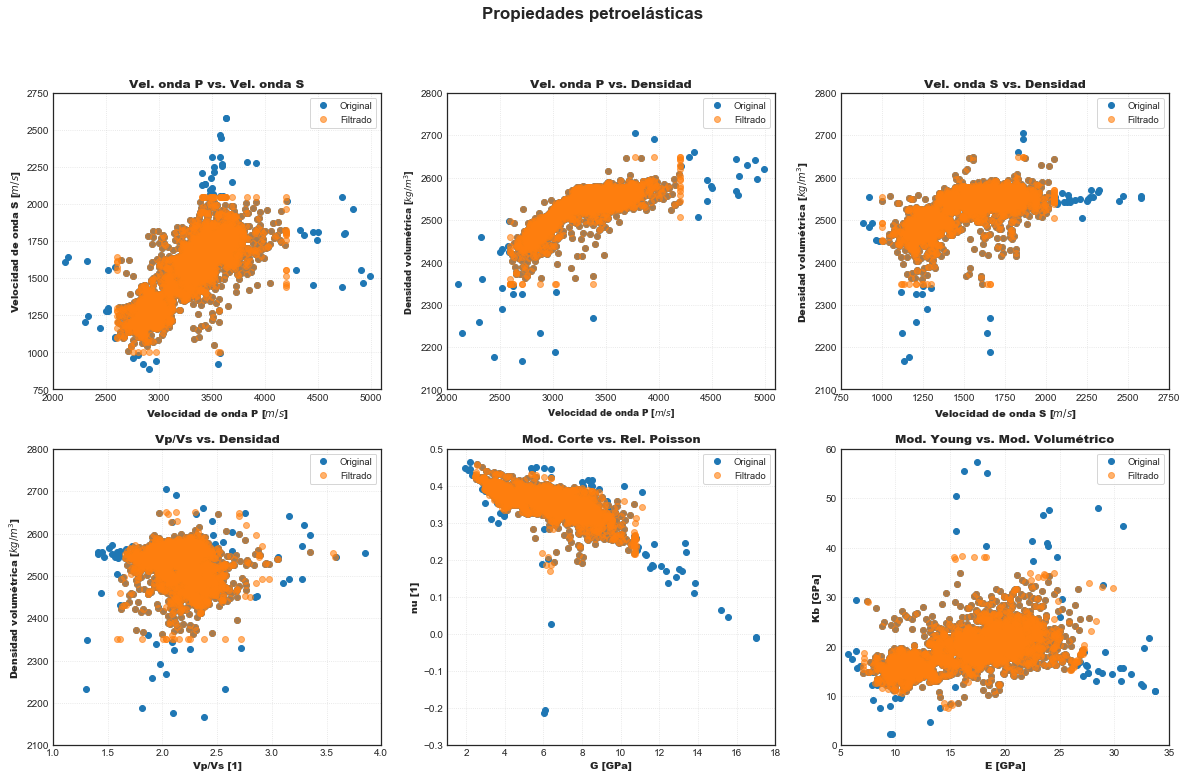

In [23]:
plt.figure(figsize=(20,12))
plt.suptitle('Propiedades petroelásticas', fontsize = 17, weight = 'bold')

plt.subplot(2,3,1)
_ = plt.plot(vp, vs, 'o', label = 'Original')
_ = plt.plot(vp_cutoff, vs_cutoff, 'o', label = 'Filtrado', alpha = 0.6)
_ = plt.xlim(2000,5100)
_ = plt.ylim(750,2750)
_ = plt.xlabel('Velocidad de onda P [$m/s$]', fontsize = 10, weight = 'black')
_ = plt.ylabel('Velocidad de onda S [$m/s$]', fontsize = 10, weight = 'black')
_ = plt.title('Vel. onda P vs. Vel. onda S', style = 'normal', fontsize = 12, weight = 'black')
_ = plt.legend(fontsize = 9.5, fancybox = True, shadow = False, frameon = True, loc = 'upper right')
_ = plt.grid(True, alpha = 0.6, linestyle=':')

plt.subplot(2,3,2)
_ = plt.plot(vp, den, 'o', label = 'Original')
_ = plt.plot(vp_cutoff, den_cutoff, 'o', label = 'Filtrado', alpha = 0.6)
_ = plt.xlim(2000,5100)
_ = plt.ylim(2100,2800)
_ = plt.xlabel('Velocidad de onda P [$m/s$]', fontsize = 9, weight = 'black')
_ = plt.ylabel('Densidad volumétrica [$kg/m^3$]', fontsize = 9, weight = 'black')
_ = plt.title('Vel. onda P vs. Densidad', style = 'normal', fontsize = 12, weight = 'black')
_ = plt.legend(fontsize = 9.5, fancybox = True, shadow = False, frameon = True, loc = 'upper right')
_ = plt.grid(True, alpha = 0.6, linestyle=':')

plt.subplot(2,3,3)
_ = plt.plot(vs, den, 'o', label = 'Original')
_ = plt.plot(vs_cutoff, den_cutoff, 'o', label = 'Filtrado', alpha = 0.6)
_ = plt.ylim(2100,2800)
_ = plt.xlim(750,2750)
_ = plt.xlabel('Velocidad de onda S [$m/s$]', fontsize = 10, weight = 'black')
_ = plt.ylabel('Densidad volumétrica [$kg/m^3$]', fontsize = 10, weight = 'black')
_ = plt.title('Vel. onda S vs. Densidad', style = 'normal', fontsize = 12, weight = 'black')
_ = plt.legend(fontsize = 9.5, fancybox = True, shadow = False, frameon = True, loc = 'upper right')
_ = plt.grid(True, alpha = 0.6, linestyle=':')

plt.subplot(2,3,4)
_ = plt.plot(vp/vs, den, 'o', label = 'Original')
_ = plt.plot(vp_cutoff/vs_cutoff, den_cutoff, 'o', label = 'Filtrado', alpha = 0.6)
_ = plt.xlim(1,4)
_ = plt.ylim(2100,2800)
_ = plt.xlabel('Vp/Vs [1]', fontsize = 10, weight = 'black')
_ = plt.ylabel('Densidad volumétrica [$kg/m^3$]', fontsize = 10, weight = 'black')
_ = plt.title('Vp/Vs vs. Densidad', style = 'normal', fontsize = 12, weight = 'black')
_ = plt.legend(fontsize = 9.5, fancybox = True, shadow = False, frameon = True, loc = 'upper right')
_ = plt.grid(True, alpha = 0.6, linestyle=':')

plt.subplot(2,3,5)
_ = plt.plot(G/1e9, nu, 'o', label = 'Original')
_ = plt.plot(Gs/1e9, nus, 'o', label = 'Filtrado', alpha = 0.6)
_ = plt.xlim(1,18)
_ = plt.ylim(-0.3,0.5)
_ = plt.xlabel('G [GPa]', fontsize = 10, weight = 'black')
_ = plt.ylabel('nu [1]', fontsize = 10, weight = 'black')
_ = plt.title('Mod. Corte vs. Rel. Poisson', style = 'normal', fontsize = 12, weight = 'black')
_ = plt.legend(fontsize = 9.5, fancybox = True, shadow = False, frameon = True, loc = 'upper right')
_ = plt.grid(True, alpha = 0.6, linestyle=':')

plt.subplot(2,3,6)
_ = plt.plot(E/1e9, Kb/1e9, 'o', label = 'Original')
_ = plt.plot(Es/1e9, Kbs/1e9, 'o', label = 'Filtrado', alpha = 0.6)
_ = plt.xlim(5,35)
_ = plt.ylim(0,60)
_ = plt.xlabel('E [GPa]', fontsize = 10, weight = 'black')
_ = plt.ylabel('Kb [GPa]', fontsize = 10, weight = 'black')
_ = plt.title('Mod. Young vs. Mod. Volumétrico', style = 'normal', fontsize = 12, weight = 'black')
_ = plt.legend(fontsize = 9.5, fancybox = True, shadow = False, frameon = True, loc = 'upper right')
_ = plt.grid(True, alpha = 0.6, linestyle=':')

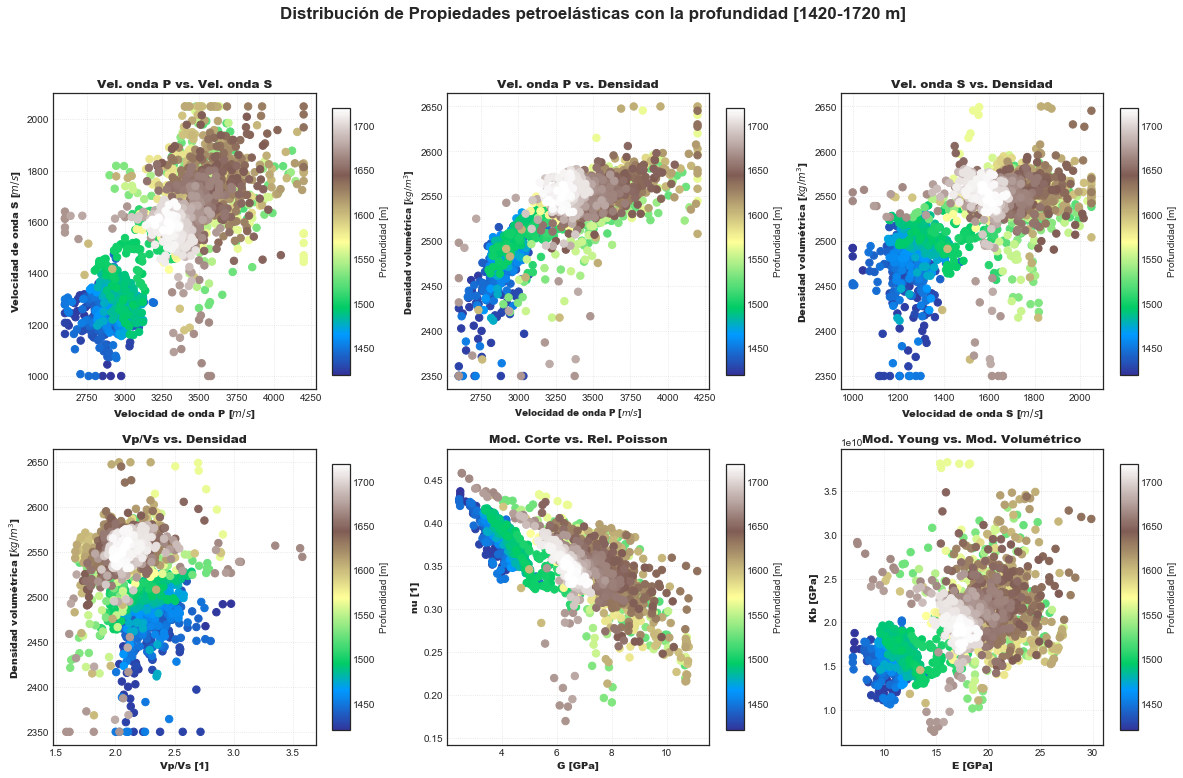

In [24]:
plt.figure(figsize=(20,12))
plt.suptitle('Distribución de Propiedades petroelásticas con la profundidad [1420-1720 m]', fontsize = 17, weight = 'bold')

plt.subplot(2,3,1)
a = plt.scatter(vp_cutoff[119:2076], vs_cutoff[119:2076], 55, prof[119:2076], cmap = 'terrain', vmin=1420, vmax=1720)
cbar= plt.colorbar(a, aspect=15, shrink=0.9, label='Profundidad [m]')
_ = plt.xlabel('Velocidad de onda P [$m/s$]', fontsize = 10, weight = 'black')
_ = plt.ylabel('Velocidad de onda S [$m/s$]', fontsize = 10, weight = 'black')
_ = plt.title('Vel. onda P vs. Vel. onda S', style = 'normal', fontsize = 12, weight = 'black')
_ = plt.grid(True, alpha = 0.6, linestyle=':')

plt.subplot(2,3,2)
a = plt.scatter(vp_cutoff[119:2076], den_cutoff[119:2076], 55, prof[119:2076], cmap = 'terrain', vmin=1420, vmax=1720)
cbar= plt.colorbar(a, aspect=15, shrink=0.9, label='Profundidad [m]')
_ = plt.xlabel('Velocidad de onda P [$m/s$]', fontsize = 9, weight = 'black')
_ = plt.ylabel('Densidad volumétrica [$kg/m^3$]', fontsize = 9, weight = 'black')
_ = plt.title('Vel. onda P vs. Densidad', style = 'normal', fontsize = 12, weight = 'black')
_ = plt.grid(True, alpha = 0.6, linestyle=':')

plt.subplot(2,3,3)
a = plt.scatter(vs_cutoff[119:2076], den_cutoff[119:2076], 55, prof[119:2076], cmap = 'terrain', vmin=1420, vmax=1720)
cbar= plt.colorbar(a, aspect=15, shrink=0.9, label='Profundidad [m]')
_ = plt.xlabel('Velocidad de onda S [$m/s$]', fontsize = 10, weight = 'black')
_ = plt.ylabel('Densidad volumétrica [$kg/m^3$]', fontsize = 10, weight = 'black')
_ = plt.title('Vel. onda S vs. Densidad', style = 'normal', fontsize = 12, weight = 'black')
_ = plt.grid(True, alpha = 0.6, linestyle=':')

plt.subplot(2,3,4)
a = plt.scatter(vp_cutoff[119:2076]/vs_cutoff[119:2076], den_cutoff[119:2076], 55, prof[119:2076], cmap = 'terrain', vmin=1420, vmax=1720)
cbar= plt.colorbar(a, aspect=15, shrink=0.9, label='Profundidad [m]')
_ = plt.xlabel('Vp/Vs [1]', fontsize = 10, weight = 'black')
_ = plt.ylabel('Densidad volumétrica [$kg/m^3$]', fontsize = 10, weight = 'black')
_ = plt.title('Vp/Vs vs. Densidad', style = 'normal', fontsize = 12, weight = 'black')
_ = plt.grid(True, alpha = 0.6, linestyle=':')

plt.subplot(2,3,5)
a = plt.scatter(Gs[119:2076]/1e9, nus[119:2076], 55, prof[119:2076], cmap = 'terrain', vmin=1420, vmax=1720)
cbar= plt.colorbar(a, aspect=15, shrink=0.9, label='Profundidad [m]')
_ = plt.xlabel('G [GPa]', fontsize = 10, weight = 'black')
_ = plt.ylabel('nu [1]', fontsize = 10, weight = 'black')
_ = plt.title('Mod. Corte vs. Rel. Poisson', style = 'normal', fontsize = 12, weight = 'black')
_ = plt.grid(True, alpha = 0.6, linestyle=':')

plt.subplot(2,3,6)
a = plt.scatter(Es[119:2076]/1e9, Kbs[119:2076], 55, prof[119:2076], cmap = 'terrain', vmin=1420, vmax=1720)
cbar= plt.colorbar(a, aspect=15, shrink=0.9, label='Profundidad [m]')
_ = plt.xlabel('E [GPa]', fontsize = 10, weight = 'black')
_ = plt.ylabel('Kb [GPa]', fontsize = 10, weight = 'black')
_ = plt.title('Mod. Young vs. Mod. Volumétrico', style = 'normal', fontsize = 12, weight = 'black')
_ = plt.grid(True, alpha = 0.6, linestyle=':')